# Final Project: Time-Series Analysis on Colombian Pork Prices

## Problem Statement
The main purpose of this project is to learn about what drives the price of pork in Colombia and be able to make demand predictions based on data found from different sources. The first question I wanted to answer was if there was a way to measure the price pork is sold in Colombia. Fortunately, there is an association in Colombia that tracks this http://asoporcicultores.co/. After talking with one of the representatives I was able to obtain two datasets. The datasets are different in that one shows the price of pork/Kg before the animal is butchered and the other after. Since the company I'm working with butcher their animals, we are going to use the second dataset. I will still use the other data later to see if it is recommendable that they sell without butchering.
## Proposed Methods and Models
Since all of the data I have collected have dates, this makes the project a Time Series(TS) problem. TS models are special because they have different assumptions than linear models. First, TS models are time dependent so the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case. Second, most TS have some form of seasonality trends (variations specific to a particular time frame). Because of the inherent properties of a TS, there are various steps involved in analyzing it:

1) Load the Data into the Ipython notebook and use pandas to handle the data.

2) Check Stationarity. A TS is said to be stationary if its statistical properties such as mean and variance remain constant over time. This is important because most of the TS models work on the assumption that the TS is stationary. We can check stationarity using the following:

        A) We can plot the moving average or moving variance and see if it varies with time.
        B) Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null 
        hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical 
        Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can 
        reject the null hypothesis and say that the series is stationary.

3) Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. If the Data obtained is not stationary, some transformations are needed. The two mayor reasons why a model is non-stationary are because of trends (varying mean over time) and seasonality (variations at specific time-frames). The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series.

4) Forecasting the Time Series. Initially my idea is to perform an Auto-Regressive Integrated Moving Averages (ARIMA) Model.

5) The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

The main idea is to be able to predict the price of pork towards the end of 2016. 


In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.arima_model as timeModel
from datetime import datetime
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import norm
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv('../Assets/Precio Semanal de Cerdo por Kg.csv')
df.head()

,Date,Antioquia,Eje,Bogot�,Valle,Nacional
0,8-Jan-10,6462.33,6189.75,6115.75,NaN,6229.16
1,15-Jan-10,6438.47,6091.18,6214.40,NaN,6194.56
2,22-Jan-10,6321.18,6162.45,6256.79,NaN,6221.21
3,29-Jan-10,6259.65,6110.11,6351.40,NaN,6186.28
4,5-Feb-10,6239.19,6127.92,6287.73,NaN,6189.93


Looking at the head of the data frame one can see that the columns need some renaming, the date needs to be formatted into a python date time and there are some NaN values in the data that need attention. The null values appear first in the region 'Valle' which probably means that they didn’t acquire data for those initial dates. After that there are some rows containing null values, that correspond to December 24 and January 1. Clearly this are national holidays in Colombia and nobody was working on collecting data. I believe that the best thing to do is to remove these dates.

In [48]:
df.describe()

,Antioquia,Eje,Bogot�,Valle,Nacional
count,335.000000,335.000000,335.000000,329.000000,335.000000
mean,5989.151582,5885.945582,6170.178448,5900.785319,5982.429522
std,465.714614,429.033896,409.407581,484.758858,435.550641
min,4646.580000,4911.830000,5202.750000,4954.460000,5060.040000
25%,5645.815000,5550.195000,5924.720000,5504.210000,5654.365000
50%,5974.230000,5894.670000,6137.920000,5833.420000,5973.050000
75%,6406.295000,6165.100000,6511.155000,6201.840000,6267.630000
max,6821.090000,6617.850000,6971.590000,6899.940000,6758.830000


The first thing to do is to do some cleaning of the data, set the index to the proper date time object, and rename some of the columns.Then plot the data and see what it looks like.

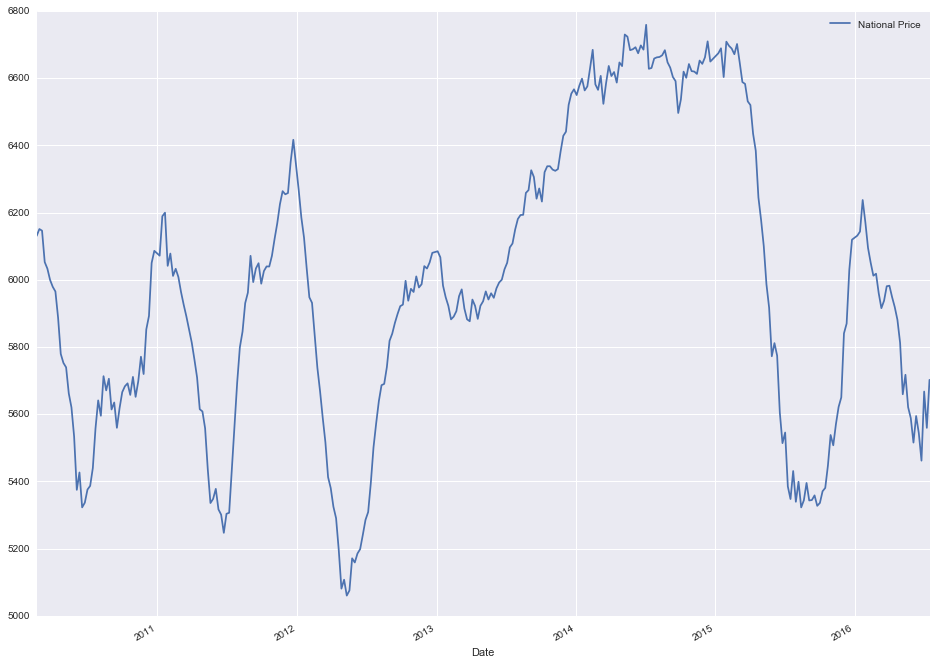

In [49]:
df.columns = ['Date','Antioquia', 'Eje_Cafetero','Bogota','Valle','Nacional']
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df = df.dropna()
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace= True)
df.index = df.index.to_datetime()
new = df['Nacional']
new = pd.DataFrame(new)
new.columns = ['National Price']
new.plot(figsize=(16, 12))

In [50]:
# Saving the data to a CSV to use it in Tableau
#new.to_csv("../Assets/nationalPriceData.csv")
new = new[(new.index < '2012-12-31')]
new

,National Price
Date,
2010-02-19,6130.76
2010-02-26,6150.95
2010-03-05,6146.05
2010-03-12,6052.61
2010-03-19,6033.04
2010-03-26,5999.59
2010-04-02,5979.02
2010-04-09,5965.06
2010-04-16,5887.10


The data is clearly non-stationary as we can see it's trending up over time and it's variance changes over time. We can create a first difference of the original series to attempt to make it stationary.

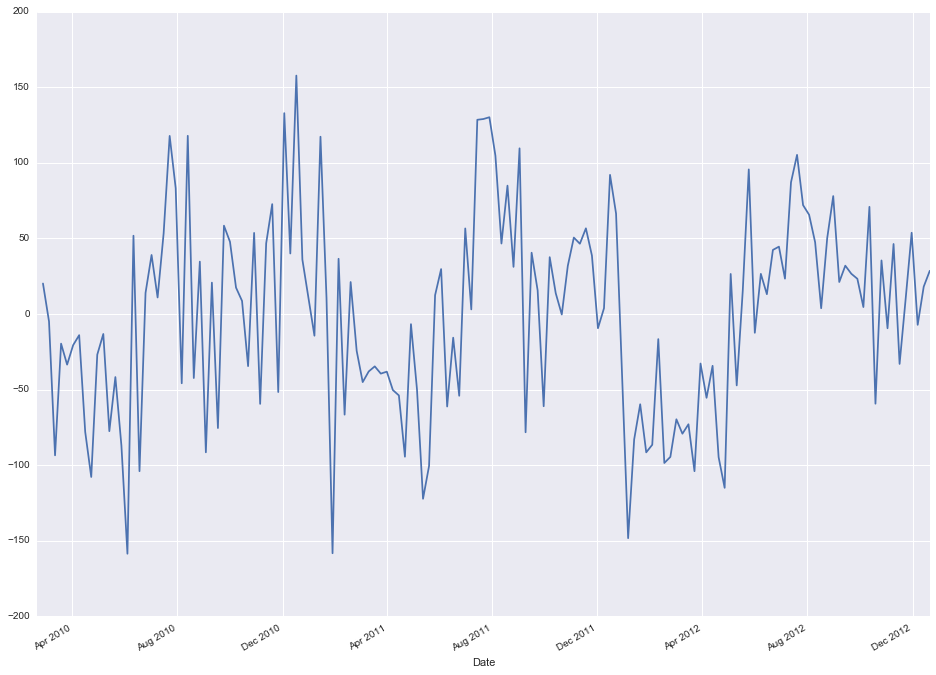

In [51]:
new['First Difference'] = new['National Price'] - new['National Price'].shift()
new['First Difference'].plot(figsize=(16, 12))

Differencing the data allows to check the behavior of the magnitude of the variance. From the graph above the magnitude of the variance is high at the begining then it flattens out but towards the end it increases again. This has to do with some abnormal years in 2013-2014 where extreme draughts in the USA affected the price of pork in Colombia. The graph of the rolling variance below better depicts this abnormal behavior(the flat area in 2013-2014).

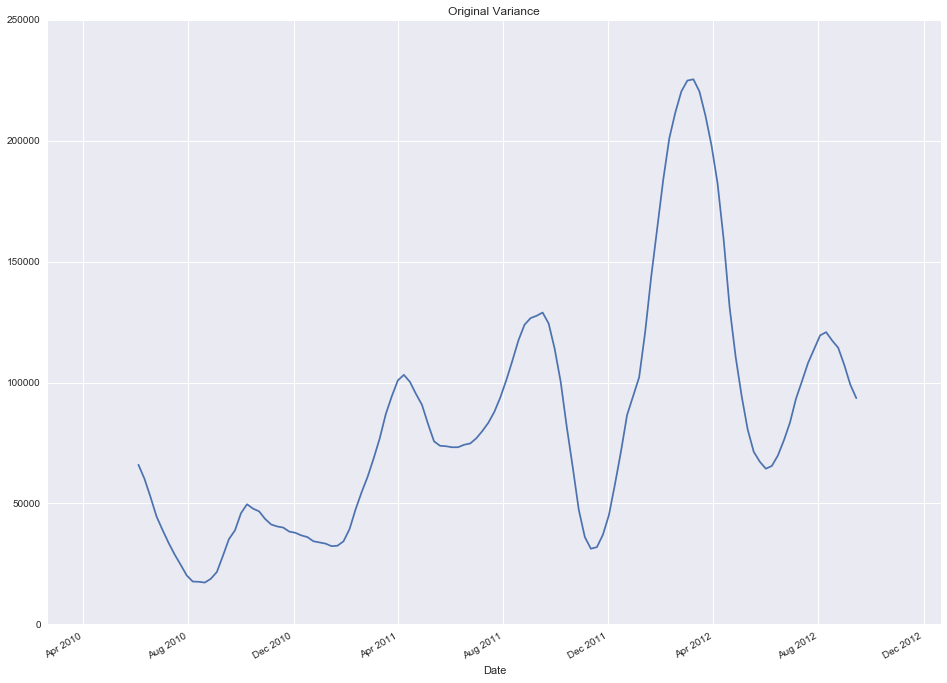

In [52]:
new['Original Variance'] = pd.rolling_var(new['National Price'], 30, min_periods=None, freq=None, center=True)  
new['Original Variance'].plot(title='Original Variance',figsize=(16, 12)) 

Now I have a stationary time series model of weekly changes to the price of pork in Colombia. Now I'm going to create some lag variables (y(t-1), y(t-2),...) and examine their relationship to y(t). I will look at 1-week lag along with monthly, quarterly and yearly lags to look for seasonal effects. One way to evaluate the relationship between lagged variables is to do a scatter plot of the original variable versus the lagged variable and see where the distribution lies.

In [53]:
new['Lag 1'] = new['First Difference'].shift()  
new['Lag 4'] = new['First Difference'].shift(4)  
new['Lag 13'] = new['First Difference'].shift(13)  
new['Lag 52'] = new['First Difference'].shift(52)

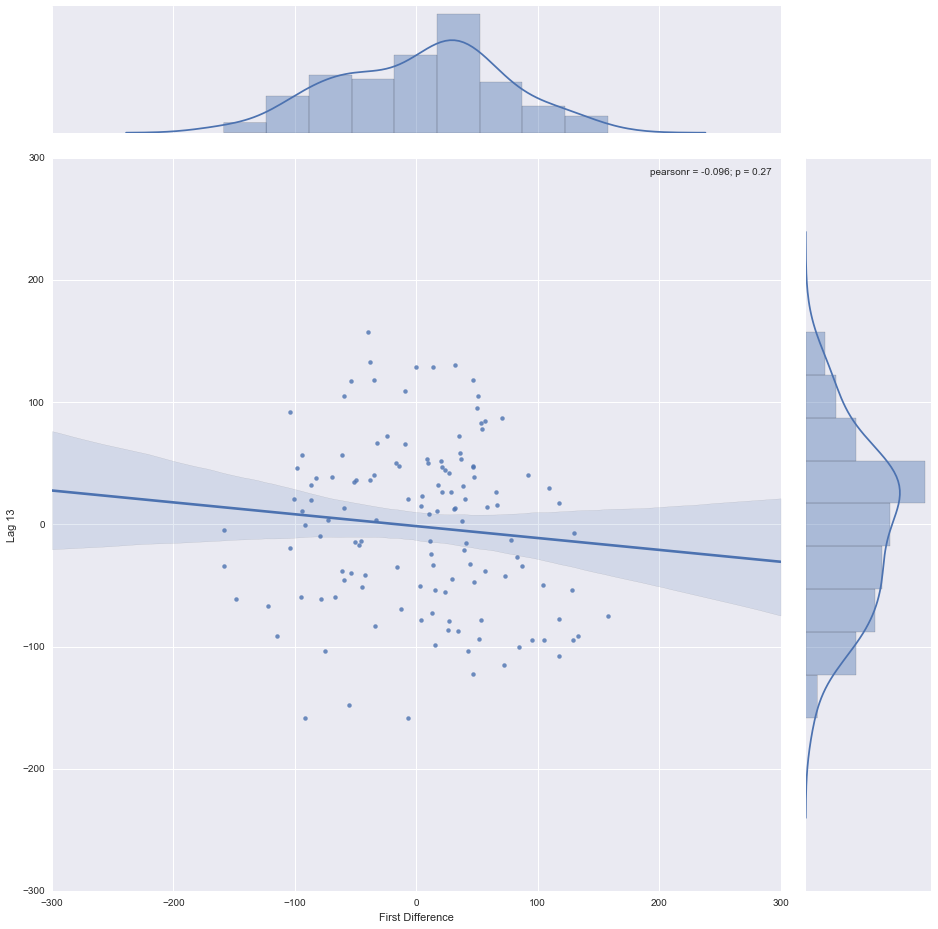

In [54]:
sns.jointplot('First Difference', 'Lag 13', new, kind='reg', size=13)

From the graph above one can see there's little correlation between the change in value from one quarter to the next. The other lagged variables show similar results. There could be a relationship to other lag steps that I haven't tried, but it's impractical to test every possible lag value manually. Fortunately there is a class of functions that can systematically do this. The auto-correlation function(acf) computes the correlation between a variable and itself at each lag step up to some limit (in this case 52). The partial auto-correlation function(pacf) computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps. We can plot the results to see if there are any significant correlations.

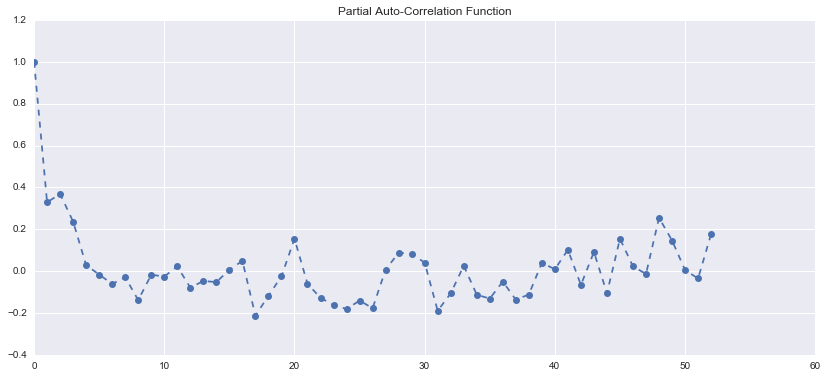

In [55]:
from statsmodels.tsa.stattools import acf, pacf  

lag_correlations = acf(new['First Difference'].iloc[1:],nlags=52)  
lag_partial_correlations = pacf(new['First Difference'].iloc[1:],nlags=52)

plt.figure(figsize=(14,6), dpi=80)
plt.plot(lag_partial_correlations , marker='o', linestyle='--') 
plt.title('Partial Auto-Correlation Function')

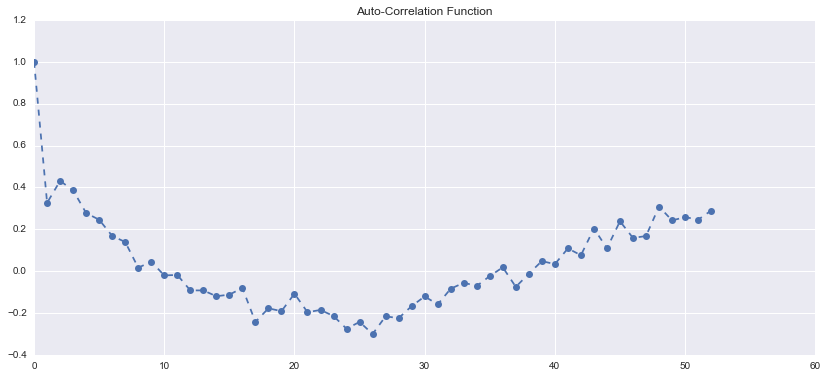

In [56]:
plt.figure(figsize=(14,6), dpi=80)
plt.plot(lag_correlations, marker='o', linestyle='--') 
plt.title('Auto-Correlation Function')

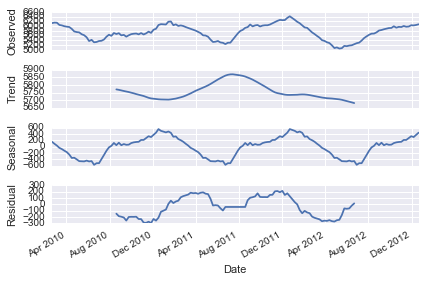

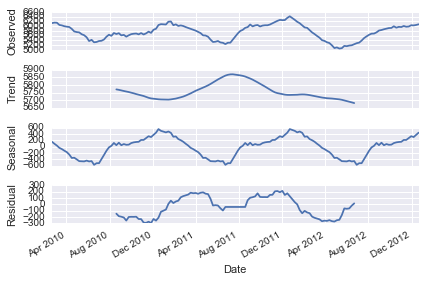

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
 
decomposition = seasonal_decompose(new['National Price'], model='additive', freq=52)  
decomposition.plot()

Reasons for parameters:
The integration order must be an integer (for example, here we assumed one order of integration, so it was specified as 1. In a pure ARMA model where the underlying data is already stationary, it would be 0).

Specifying the model in Statsmodels is done simply by adding the seasonal_order argument, which accepts a tuple of the form (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity). The seasonal AR and MA specifications, as before, can be expressed as a maximum polynomial degree or as the lag polynomial itself. Seasonal periodicity is an integer in this case 52 weeks.

In [62]:
mod = sm.tsa.statespace.SARIMAX(new['National Price'], order=(0,1,1),seasonal_order=(0,1,1,52))
res = mod.fit()

ValueError: maxlag should be < nobs

In [59]:
# Obtaining in sample prediction and forecasting for the next year
nforecast = 52
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))[1:]
predict_ci = predict.conf_int(alpha=0.5)
# Adding my predictions confidence interval to the data frame
rng = pd.date_range('2010-02-19', periods=len(predict_ci), freq='7D')
predict_ci.index = rng
new = pd.concat([new, predict_ci], axis=1)
new

,National Price,First Difference,Original Variance,Lag 1,Lag 4,Lag 13,Lag 52,lower National Price,upper National Price
2010-02-19,6130.76,NaN,NaN,NaN,NaN,NaN,NaN,-955.942494,955.942494
2010-02-26,6150.95,20.19,NaN,NaN,NaN,NaN,NaN,5458.751731,6813.578536
2010-03-05,6146.05,-4.90,NaN,20.19,NaN,NaN,NaN,5473.563075,6828.388841
2010-03-12,6052.61,-93.44,NaN,-4.90,NaN,NaN,NaN,5468.628469,6823.454234
2010-03-19,6033.04,-19.57,NaN,-93.44,NaN,NaN,NaN,5375.033080,6729.858846
2010-03-26,5999.59,-33.45,NaN,-19.57,20.19,NaN,NaN,5355.593046,6710.418812
2010-04-02,5979.02,-20.57,NaN,-33.45,-4.90,NaN,NaN,5322.118449,6676.944215
2010-04-09,5965.06,-13.96,NaN,-20.57,-93.44,NaN,NaN,5301.571105,6656.396871
2010-04-16,5887.10,-77.96,NaN,-13.96,-19.57,NaN,NaN,5287.622671,6642.448437
2010-04-23,5779.33,-107.77,NaN,-77.96,-33.45,NaN,NaN,5209.550286,6564.376052


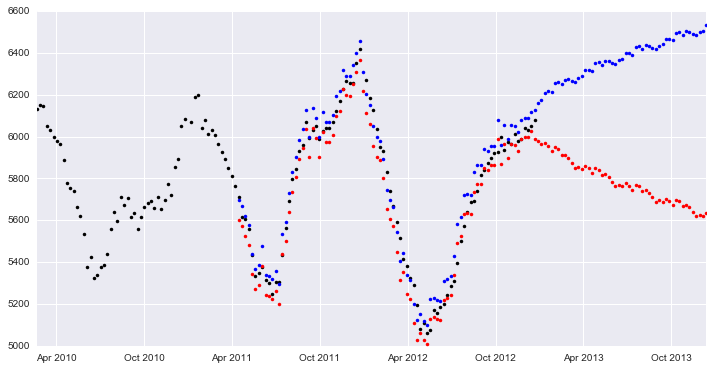

In [60]:
# Graph
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(new['National Price'], 'k.')
ax.plot(new[60:]['lower National Price'], 'r.')
ax.plot(new[60:]['upper National Price'], 'b.')

#ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
#ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)

In [61]:
new

,National Price,First Difference,Original Variance,Lag 1,Lag 4,Lag 13,Lag 52,lower National Price,upper National Price
2010-02-19,6130.76,NaN,NaN,NaN,NaN,NaN,NaN,-955.942494,955.942494
2010-02-26,6150.95,20.19,NaN,NaN,NaN,NaN,NaN,5458.751731,6813.578536
2010-03-05,6146.05,-4.90,NaN,20.19,NaN,NaN,NaN,5473.563075,6828.388841
2010-03-12,6052.61,-93.44,NaN,-4.90,NaN,NaN,NaN,5468.628469,6823.454234
2010-03-19,6033.04,-19.57,NaN,-93.44,NaN,NaN,NaN,5375.033080,6729.858846
2010-03-26,5999.59,-33.45,NaN,-19.57,20.19,NaN,NaN,5355.593046,6710.418812
2010-04-02,5979.02,-20.57,NaN,-33.45,-4.90,NaN,NaN,5322.118449,6676.944215
2010-04-09,5965.06,-13.96,NaN,-20.57,-93.44,NaN,NaN,5301.571105,6656.396871
2010-04-16,5887.10,-77.96,NaN,-13.96,-19.57,NaN,NaN,5287.622671,6642.448437
2010-04-23,5779.33,-107.77,NaN,-77.96,-33.45,NaN,NaN,5209.550286,6564.376052
